In [7]:
import sys
import os

# Add Codes/src to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../src')))

In [8]:
import pandas as pd
import numpy as np
import torch
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

from train_utils import BatteryTrainerBase

In [9]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [10]:
df = pd.read_pickle('../../../Datasets/processed/merged_interp_flat.pkl')
df.head()

,cell_id,rated_capacity,cycle_index,capacity,soh,dqdt_min,dqdt_max,dqdt_mean,dqdt_std,dvdt_min,...,i_interp_991,i_interp_992,i_interp_993,i_interp_994,i_interp_995,i_interp_996,i_interp_997,i_interp_998,i_interp_999,source
0,B0005,2.0,1,1.856487,0.928244,-1.332504e-07,0.002876,0.000528,0.000255,-0.006229,...,0.004819,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,nasa
1,B0005,2.0,3,1.846327,0.923164,-4.510385e-07,0.002894,0.000527,0.000257,-0.006004,...,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,nasa
2,B0005,2.0,5,1.835349,0.917675,-1.163391e-07,0.002333,0.000520,0.000227,-0.005953,...,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,nasa
3,B0005,2.0,7,1.835263,0.917631,-2.062661e-07,0.002885,0.000530,0.000255,-0.005907,...,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,nasa
4,B0005,2.0,9,1.834646,0.917323,-5.353266e-07,0.002896,0.000530,0.000256,-0.005923,...,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,nasa


In [11]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna

class SimpleTransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # [batch_size, seq_len=1, d_model]
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.regressor(x).squeeze(1)

class BatteryTrainer(BatteryTrainerBase):
    def train(self, train_df, val_df, feature_cols=None, d_model=64, nhead=4, num_layers=2, lr=1e-3, epochs=50, batch_size=16):
        X_train = torch.tensor(train_df[feature_cols].values, dtype=torch.float32)
        y_train = torch.tensor(train_df[self.target_cols].values.ravel(), dtype=torch.float32)
        X_val = torch.tensor(val_df[feature_cols].values, dtype=torch.float32)
        y_val = torch.tensor(val_df[self.target_cols].values.ravel(), dtype=torch.float32)

        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

        self.model = SimpleTransformerRegressor(input_dim=X_train.shape[1], d_model=d_model, nhead=nhead, num_layers=num_layers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        self.model.train()
        for epoch in range(epochs):
            for xb, yb in train_loader:
                pred = self.model(xb)
                loss = loss_fn(pred, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        self.model.eval()
        with torch.no_grad():
            y_pred = self.model(X_val).numpy()

        print(f"Transformer Val MSE={mean_squared_error(y_val, y_pred):.4f}, MAE={mean_absolute_error(y_val, y_pred):.4f}, R²={r2_score(y_val, y_pred):.4f}")
        return self.model, y_val.numpy(), y_pred

    def optuna_objective(self, trial):
        d_model = trial.suggest_categorical("d_model", [32, 64, 128])
        nhead = trial.suggest_categorical("nhead", [2, 4, 8])
        num_layers = trial.suggest_int("num_layers", 1, 3)
        lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])

        self.cross_validate(
            d_model=d_model,
            nhead=nhead,
            num_layers=num_layers,
            lr=lr,
            batch_size=batch_size
        )
        return np.mean(self.mse_scores)


In [12]:
trainer = BatteryTrainer(df, target_cols=['soh'])

In [13]:
result = trainer.cross_validate()


=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0113, MAE=0.0627, R²=0.8023
  MSE: 0.0113, MAE: 0.0627, R²: 0.8023

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0042, MAE=0.0531, R²=0.8780
  MSE: 0.0042, MAE: 0.0531, R²: 0.8780

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0089, MAE=0.0693, R²=0.8064
  MSE: 0.0089, MAE: 0.0693, R²: 0.8064

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0010, MAE=0.0175, R²=0.9741
  MSE: 0.0010, MAE: 0.0175, R²: 0.9741

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0017, MAE=0.0190, R²=0.9766
  MSE: 0.0017, MAE: 0.0190, R²: 0.9766

=== Average CV Performance ===
Avg MSE: 0.0054
Avg MAE: 0.0443
Avg R² : 0.8875


In [14]:
study = trainer.run_optuna_tuning()

[I 2025-04-17 13:41:38,102] A new study created in memory with name: no-name-14c2c9d6-b5d3-4107-9ddb-25e305252a23



=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0271, MAE=0.1106, R²=0.5256
  MSE: 0.0271, MAE: 0.1106, R²: 0.5256

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0089, MAE=0.0641, R²=0.7385
  MSE: 0.0089, MAE: 0.0641, R²: 0.7385

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0034, MAE=0.0409, R²=0.9261
  MSE: 0.0034, MAE: 0.0409, R²: 0.9261

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0014, MAE=0.0266, R²=0.9618
  MSE: 0.0014, MAE: 0.0266, R²: 0.9618

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2025-04-17 13:46:44,727] Trial 0 finished with value: 0.00901204461697489 and parameters: {'d_model': 64, 'nhead': 2, 'num_layers': 1, 'lr': 0.005399484409787433, 'batch_size': 16}. Best is trial 0 with value: 0.00901204461697489.


Transformer Val MSE=0.0042, MAE=0.0403, R²=0.9421
  MSE: 0.0042, MAE: 0.0403, R²: 0.9421

=== Average CV Performance ===
Avg MSE: 0.0090
Avg MAE: 0.0565
Avg R² : 0.8188

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0050, MAE=0.0440, R²=0.9124
  MSE: 0.0050, MAE: 0.0440, R²: 0.9124

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0028, MAE=0.0333, R²=0.9194
  MSE: 0.0028, MAE: 0.0333, R²: 0.9194

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0018, MAE=0.0259, R²=0.9608
  MSE: 0.0018, MAE: 0.0259, R²: 0.9608

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0006, MAE=0.0152, R²=0.9830
  MSE: 0.0006, MAE: 0.0152, R²: 0.9830

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2025-04-17 14:10:41,407] Trial 1 finished with value: 0.0023292360128834844 and parameters: {'d_model': 32, 'nhead': 8, 'num_layers': 2, 'lr': 0.0007309539835912913, 'batch_size': 16}. Best is trial 1 with value: 0.0023292360128834844.


Transformer Val MSE=0.0014, MAE=0.0193, R²=0.9800
  MSE: 0.0014, MAE: 0.0193, R²: 0.9800

=== Average CV Performance ===
Avg MSE: 0.0023
Avg MAE: 0.0276
Avg R² : 0.9511

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0015, MAE=0.0212, R²=0.9736
  MSE: 0.0015, MAE: 0.0212, R²: 0.9736

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0042, MAE=0.0443, R²=0.8780
  MSE: 0.0042, MAE: 0.0443, R²: 0.8780

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0014, MAE=0.0273, R²=0.9696
  MSE: 0.0014, MAE: 0.0273, R²: 0.9696

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0006, MAE=0.0170, R²=0.9844
  MSE: 0.0006, MAE: 0.0170, R²: 0.9844

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2025-04-17 14:34:53,721] Trial 2 finished with value: 0.0018441181280650198 and parameters: {'d_model': 128, 'nhead': 2, 'num_layers': 2, 'lr': 0.0001238513729886094, 'batch_size': 8}. Best is trial 2 with value: 0.0018441181280650198.


Transformer Val MSE=0.0016, MAE=0.0224, R²=0.9783
  MSE: 0.0016, MAE: 0.0224, R²: 0.9783

=== Average CV Performance ===
Avg MSE: 0.0018
Avg MAE: 0.0264
Avg R² : 0.9568

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0021, MAE=0.0302, R²=0.9634
  MSE: 0.0021, MAE: 0.0302, R²: 0.9634

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0129, MAE=0.0759, R²=0.6241
  MSE: 0.0129, MAE: 0.0759, R²: 0.6241

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0018, MAE=0.0264, R²=0.9610
  MSE: 0.0018, MAE: 0.0264, R²: 0.9610

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0009, MAE=0.0195, R²=0.9749
  MSE: 0.0009, MAE: 0.0195, R²: 0.9749

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2025-04-17 14:42:01,769] Trial 3 finished with value: 0.004008031904231757 and parameters: {'d_model': 64, 'nhead': 8, 'num_layers': 2, 'lr': 0.00017541893487450815, 'batch_size': 32}. Best is trial 2 with value: 0.0018441181280650198.


Transformer Val MSE=0.0024, MAE=0.0310, R²=0.9672
  MSE: 0.0024, MAE: 0.0310, R²: 0.9672

=== Average CV Performance ===
Avg MSE: 0.0040
Avg MAE: 0.0366
Avg R² : 0.8981

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0167, MAE=0.0785, R²=0.7085
  MSE: 0.0167, MAE: 0.0785, R²: 0.7085

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0219, MAE=0.1214, R²=0.3594
  MSE: 0.0219, MAE: 0.1214, R²: 0.3594

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0459, MAE=0.1654, R²=-0.0007
  MSE: 0.0459, MAE: 0.1654, R²: -0.0007

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0208, MAE=0.1147, R²=0.4451
  MSE: 0.0208, MAE: 0.1147, R²: 0.4451

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2025-04-17 16:13:30,480] Trial 4 finished with value: 0.02471935823559761 and parameters: {'d_model': 64, 'nhead': 4, 'num_layers': 3, 'lr': 0.0035503048581283078, 'batch_size': 8}. Best is trial 2 with value: 0.0018441181280650198.


Transformer Val MSE=0.0183, MAE=0.0874, R²=0.7450
  MSE: 0.0183, MAE: 0.0874, R²: 0.7450

=== Average CV Performance ===
Avg MSE: 0.0247
Avg MAE: 0.1135
Avg R² : 0.4515

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0039, MAE=0.0443, R²=0.9323
  MSE: 0.0039, MAE: 0.0443, R²: 0.9323

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0046, MAE=0.0452, R²=0.8655
  MSE: 0.0046, MAE: 0.0452, R²: 0.8655

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0047, MAE=0.0522, R²=0.8981
  MSE: 0.0047, MAE: 0.0522, R²: 0.8981

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0018, MAE=0.0278, R²=0.9529
  MSE: 0.0018, MAE: 0.0278, R²: 0.9529

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2025-04-17 16:18:09,816] Trial 5 finished with value: 0.0034784421324729918 and parameters: {'d_model': 32, 'nhead': 8, 'num_layers': 1, 'lr': 0.004544383960336014, 'batch_size': 32}. Best is trial 2 with value: 0.0018441181280650198.


Transformer Val MSE=0.0025, MAE=0.0312, R²=0.9655
  MSE: 0.0025, MAE: 0.0312, R²: 0.9655

=== Average CV Performance ===
Avg MSE: 0.0035
Avg MAE: 0.0401
Avg R² : 0.9229

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0106, MAE=0.0674, R²=0.8154
  MSE: 0.0106, MAE: 0.0674, R²: 0.8154

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0073, MAE=0.0587, R²=0.7856
  MSE: 0.0073, MAE: 0.0587, R²: 0.7856

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0061, MAE=0.0589, R²=0.8679
  MSE: 0.0061, MAE: 0.0589, R²: 0.8679

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0080, MAE=0.0738, R²=0.7864
  MSE: 0.0080, MAE: 0.0738, R²: 0.7864

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2025-04-17 16:22:27,216] Trial 6 finished with value: 0.006953415600582958 and parameters: {'d_model': 64, 'nhead': 2, 'num_layers': 1, 'lr': 0.004274869455295219, 'batch_size': 32}. Best is trial 2 with value: 0.0018441181280650198.


Transformer Val MSE=0.0028, MAE=0.0332, R²=0.9609
  MSE: 0.0028, MAE: 0.0332, R²: 0.9609

=== Average CV Performance ===
Avg MSE: 0.0070
Avg MAE: 0.0584
Avg R² : 0.8432

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0041, MAE=0.0413, R²=0.9284
  MSE: 0.0041, MAE: 0.0413, R²: 0.9284

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0033, MAE=0.0385, R²=0.9041
  MSE: 0.0033, MAE: 0.0385, R²: 0.9041

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0030, MAE=0.0436, R²=0.9336
  MSE: 0.0030, MAE: 0.0436, R²: 0.9336

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0011, MAE=0.0267, R²=0.9698
  MSE: 0.0011, MAE: 0.0267, R²: 0.9698

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2025-04-17 16:29:35,088] Trial 7 finished with value: 0.002573969541117549 and parameters: {'d_model': 64, 'nhead': 2, 'num_layers': 1, 'lr': 0.0004187594718900631, 'batch_size': 16}. Best is trial 2 with value: 0.0018441181280650198.


Transformer Val MSE=0.0013, MAE=0.0166, R²=0.9816
  MSE: 0.0013, MAE: 0.0166, R²: 0.9816

=== Average CV Performance ===
Avg MSE: 0.0026
Avg MAE: 0.0333
Avg R² : 0.9435

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0016, MAE=0.0230, R²=0.9715
  MSE: 0.0016, MAE: 0.0230, R²: 0.9715

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0026, MAE=0.0298, R²=0.9253
  MSE: 0.0026, MAE: 0.0298, R²: 0.9253

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0011, MAE=0.0194, R²=0.9753
  MSE: 0.0011, MAE: 0.0194, R²: 0.9753

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0025, MAE=0.0360, R²=0.9342
  MSE: 0.0025, MAE: 0.0360, R²: 0.9342

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2025-04-17 16:46:05,409] Trial 8 finished with value: 0.0018433154793456197 and parameters: {'d_model': 32, 'nhead': 4, 'num_layers': 3, 'lr': 0.0009718319944817398, 'batch_size': 8}. Best is trial 8 with value: 0.0018433154793456197.


Transformer Val MSE=0.0014, MAE=0.0177, R²=0.9801
  MSE: 0.0014, MAE: 0.0177, R²: 0.9801

=== Average CV Performance ===
Avg MSE: 0.0018
Avg MAE: 0.0252
Avg R² : 0.9573

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0046, MAE=0.0450, R²=0.9188
  MSE: 0.0046, MAE: 0.0450, R²: 0.9188

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0095, MAE=0.0673, R²=0.7220
  MSE: 0.0095, MAE: 0.0673, R²: 0.7220

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0050, MAE=0.0513, R²=0.8913
  MSE: 0.0050, MAE: 0.0513, R²: 0.8913

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0098, MAE=0.0747, R²=0.7398
  MSE: 0.0098, MAE: 0.0747, R²: 0.7398

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2025-04-17 16:55:12,680] Trial 9 finished with value: 0.006855203583836555 and parameters: {'d_model': 128, 'nhead': 8, 'num_layers': 1, 'lr': 0.000661859559718348, 'batch_size': 8}. Best is trial 8 with value: 0.0018433154793456197.


Transformer Val MSE=0.0054, MAE=0.0547, R²=0.9251
  MSE: 0.0054, MAE: 0.0547, R²: 0.9251

=== Average CV Performance ===
Avg MSE: 0.0069
Avg MAE: 0.0586
Avg R² : 0.8394

Best trial:
  MSE: 0.0018
  Params:
    d_model: 32
    nhead: 4
    num_layers: 3
    lr: 0.0009718319944817398
    batch_size: 8


In [15]:
base_model = trainer.train_base_model()


Training base model with default hyperparameters


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0029, MAE=0.0242, R²=0.9497


In [16]:
tuned_model = trainer.train_tuned_model()


Training with best Optuna params:
  d_model: 32
  nhead: 4
  num_layers: 3
  lr: 0.0009718319944817398
  batch_size: 8


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0038, MAE=0.0323, R²=0.9338



Running cross-validation for base model...

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0045, MAE=0.0353, R²=0.9209
  MSE: 0.0045, MAE: 0.0353, R²: 0.9209

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0049, MAE=0.0451, R²=0.8572
  MSE: 0.0049, MAE: 0.0451, R²: 0.8572

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0025, MAE=0.0332, R²=0.9464
  MSE: 0.0025, MAE: 0.0332, R²: 0.9464

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0015, MAE=0.0240, R²=0.9604
  MSE: 0.0015, MAE: 0.0240, R²: 0.9604

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0038, MAE=0.0400, R²=0.9476
  MSE: 0.0038, MAE: 0.0400, R²: 0.9476

=== Average CV Performance ===
Avg MSE: 0.0034
Avg MAE: 0.0355
Avg R² : 0.9265

Running cross-validation for tuned model...

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0014, MAE=0.0190, R²=0.9761
  MSE: 0.0014, MAE: 0.0190, R²: 0.9761

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0047, MAE=0.0459, R²=0.8628
  MSE: 0.0047, MAE: 0.0459, R²: 0.8628

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0011, MAE=0.0171, R²=0.9758
  MSE: 0.0011, MAE: 0.0171, R²: 0.9758

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0014, MAE=0.0229, R²=0.9634
  MSE: 0.0014, MAE: 0.0229, R²: 0.9634

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


c:\Users\chris\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer Val MSE=0.0015, MAE=0.0199, R²=0.9794
  MSE: 0.0015, MAE: 0.0199, R²: 0.9794

=== Average CV Performance ===
Avg MSE: 0.0020
Avg MAE: 0.0250
Avg R² : 0.9515


c:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future vers

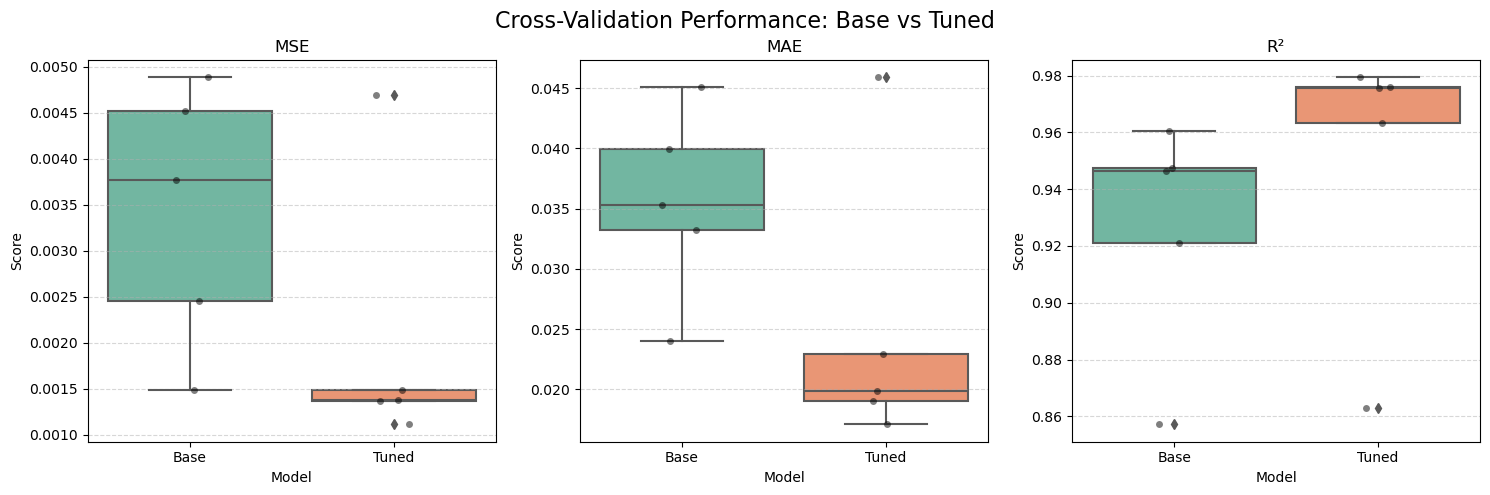

In [17]:
trainer.compare_base_vs_tuned_cv()